# 1. Introdução e Objetivos

**Objetivo:** prever a variável binária **`sold`** (1/0) para artigos *pink label* usando **Random Forest**.

**Abordagem geral:**
- Divisão **estratificada** em *train/validation/test* respeitando proporções;
- Criação de um primeiro modelo **Random Forest** que será a baseline;
- *Hyperparameter tuning* (leve) com `RandomizedSearchCV`para procurar melhorias relativamente aos resultados obtidos na baseline;
- Avaliação do desempenho das métricas de *accuracy*, *precision*, *recall* e *F0.5*, considerando a variação do **threshold** de decisão;
- **Explicabilidade** do modelo através da análise da importância das variáveis;
- **Exportação** de artefactos (pipeline, métricas) para posterior utilização em fases de deployment ou estudos;


> **Nota:**  
> Partimos de um dataset já preparado para utilização no modelo (tratamento prévio de *missing values*, outliers e inconsistências), carregado a partir do ficheiro **Datacluster_store_sku.csv**.  
>   
> O pré-processamento neste script é **mínimo**, limitando-se à normalização das variáveis, para garantir que o mesmo *scaler* obtido no *training set* seja aplicado também ao *validation* e *test set*.  
>   
> Para treinar os modelos, será utilizado o objeto **Pipeline** do *scikit-learn*, permitindo aplicar um fluxo de pré-processamento cujos passos definidos são neutros na prática (dado que o tratamento já foi feito previamente), mas que aqui são incluídos como **demonstração de abordagem e potencialidades** da biblioteca.

## 2. Setup e Imports

In [1]:
import sys, os, json, random, time
from typing import List, Dict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
                             confusion_matrix, roc_curve, auc, precision_recall_curve,fbeta_score)
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted
from sklearn.preprocessing import StandardScaler
import joblib

# Reprodutibilidade
SEED = 42
def set_seed(seed: int = 42):
    import numpy as _np, random as _random
    _random.seed(seed)
    _np.random.seed(seed)
set_seed(SEED)

# Versões
print('Python:', sys.version.split()[0])
import sklearn, matplotlib
print('pandas:', pd.__version__)
print('numpy:', np.__version__)
print('sklearn:', sklearn.__version__)
print('matplotlib:', matplotlib.__version__)

# Opções pandas
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 160)

Python: 3.12.11
pandas: 2.2.2
numpy: 2.0.2
sklearn: 1.6.1
matplotlib: 3.10.0


## 3. Carregamento de Dados

In [2]:
candidates = [
    '/content/Datacluster_store_sku.csv'
]

df = None
for p in candidates:
    if os.path.exists(p):
        df = pd.read_csv(p)
        print(f'Loaded dataset from: {p}')
        break
if df is None:
    raise FileNotFoundError('Ficheiro não encontrado. Ajustar o caminho.')

print('Shape:', df.shape)
display(df.head(5))
print()
df.info()

Loaded dataset from: /content/Datacluster_store_sku.csv
Shape: (149978, 64)


,oldpvp,weight (g),Margin (%),Profit (€),perc_expiring_sku,sold,selling_square_ft,newpvp,discount,d_Marca 1,d_Marca 10,d_Marca 11,d_Marca 12,d_Marca 13,d_Marca 14,d_Marca 15,d_Marca 16,d_Marca 17,d_Marca 18,d_Marca 19,d_Marca 2,d_Marca 20,d_Marca 21,d_Marca 22,d_Marca 23,d_Marca 24,d_Marca 25,d_Marca 26,d_Marca 27,d_Marca 28,d_Marca 29,d_Marca 3,d_Marca 30,d_Marca 31,d_Marca 32,d_Marca 33,d_Marca 34,d_Marca 35,d_Marca 36,d_Marca 37,d_Marca 38,d_Marca 39,d_Marca 4,d_Marca 40,d_Marca 41,d_Marca 42,d_Marca 5,d_Marca 6,d_Marca 7,d_Marca 8,d_Marca 9,type_encoded,labelling_dow_sin,labelling_dow_cos,expiring_dow_sin,expiring_dow_cos,StoreCluster_0,StoreCluster_1,StoreCluster_2,StoreCluster_3,SKUCluster_0,SKUCluster_1,SKUCluster_2,SKUCluster_3
0,4.22,260.0,0.16,0.3376,0.010050,1,4762.0,2.11,0.5,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,3,-0.433884,-0.900969,-0.781831,0.623490,True,False,False,False,False,False,True,False
1,3.96,260.0,0.16,0.3168,0.005025,0,4762.0,1.98,0.5,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,3,-0.433884,-0.900969,-0.974928,-0.222521,True,False,False,False,False,False,True,False
2,4.74,260.0,0.16,0.3792,0.010050,1,4762.0,2.37,0.5,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,3,-0.433884,-0.900969,-0.781831,0.623490,True,False,False,False,False,False,True,False
3,4.20,260.0,0.16,0.3360,0.010050,1,4762.0,2.10,0.5,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,3,-0.433884,-0.900969,-0.781831,0.623490,True,False,False,False,False,False,True,False
4,4.62,260.0,0.16,0.3696,0.010050,1,4762.0,2.31,0.5,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,3,-0.433884,-0.900969,-0.781831,0.623490,True,False,False,False,False,False,True,False



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149978 entries, 0 to 149977
Data columns (total 64 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   oldpvp             149978 non-null  float64
 1   weight (g)         149978 non-null  float64
 2   Margin (%)         149978 non-null  float64
 3   Profit (€)         149978 non-null  float64
 4   perc_expiring_sku  149978 non-null  float64
 5   sold               149978 non-null  int64  
 6   selling_square_ft  149978 non-null  float64
 7   newpvp             149978 non-null  float64
 8   discount           149978 non-null  float64
 9   d_Marca 1          149978 non-null  bool   
 10  d_Marca 10         149978 non-null  bool   
 11  d_Marca 11         149978 non-null  bool   
 12  d_Marca 12         149978 non-null  bool   
 13  d_Marca 13         149978 non-null  bool   
 14  d_Marca 14         149978 non-null  bool   
 15  d_Marca 15         149978 non-null  bool   
 16  d

In [3]:
df.head()

,oldpvp,weight (g),Margin (%),Profit (€),perc_expiring_sku,sold,selling_square_ft,newpvp,discount,d_Marca 1,d_Marca 10,d_Marca 11,d_Marca 12,d_Marca 13,d_Marca 14,d_Marca 15,d_Marca 16,d_Marca 17,d_Marca 18,d_Marca 19,d_Marca 2,d_Marca 20,d_Marca 21,d_Marca 22,d_Marca 23,d_Marca 24,d_Marca 25,d_Marca 26,d_Marca 27,d_Marca 28,d_Marca 29,d_Marca 3,d_Marca 30,d_Marca 31,d_Marca 32,d_Marca 33,d_Marca 34,d_Marca 35,d_Marca 36,d_Marca 37,d_Marca 38,d_Marca 39,d_Marca 4,d_Marca 40,d_Marca 41,d_Marca 42,d_Marca 5,d_Marca 6,d_Marca 7,d_Marca 8,d_Marca 9,type_encoded,labelling_dow_sin,labelling_dow_cos,expiring_dow_sin,expiring_dow_cos,StoreCluster_0,StoreCluster_1,StoreCluster_2,StoreCluster_3,SKUCluster_0,SKUCluster_1,SKUCluster_2,SKUCluster_3
0,4.22,260.0,0.16,0.3376,0.010050,1,4762.0,2.11,0.5,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,3,-0.433884,-0.900969,-0.781831,0.623490,True,False,False,False,False,False,True,False
1,3.96,260.0,0.16,0.3168,0.005025,0,4762.0,1.98,0.5,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,3,-0.433884,-0.900969,-0.974928,-0.222521,True,False,False,False,False,False,True,False
2,4.74,260.0,0.16,0.3792,0.010050,1,4762.0,2.37,0.5,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,3,-0.433884,-0.900969,-0.781831,0.623490,True,False,False,False,False,False,True,False
3,4.20,260.0,0.16,0.3360,0.010050,1,4762.0,2.10,0.5,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,3,-0.433884,-0.900969,-0.781831,0.623490,True,False,False,False,False,False,True,False
4,4.62,260.0,0.16,0.3696,0.010050,1,4762.0,2.31,0.5,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,3,-0.433884,-0.900969,-0.781831,0.623490,True,False,False,False,False,False,True,False


In [4]:
# Para evitar erros na leitura de variáveis binárias do ficheiro csv
## Converter colunas object para boolean se só tiverem valores True/False
for col in df.select_dtypes(include="object").columns:
    # Normalizar valores para lower-case (evita problemas "TRUE"/"true")
    uniques = df[col].dropna().unique()
    lower_uniques = set(str(v).strip().lower() for v in uniques)

    if lower_uniques.issubset({"true", "false"}):
        df[col] = df[col].str.strip().str.lower().map({"true": True, "false": False})


### Extra - Remoção de colunas e Flags

In [5]:
if "flag" in df.columns:
    df_ori = df.copy()
    df = df[df["flag"] == 0]
    print(f"Registos filtrados com flag == 0: {len(df)}")
else:
    print("Coluna 'flag' não encontrada no DataFrame")

# Remover colunas 'sku' e 'flag'
cols_to_drop = [col for col in ["sku", "flag","idstore"] if col in df.columns]
df = df.drop(columns=cols_to_drop).copy()

print(f"Drop columns: {cols_to_drop}")


Coluna 'flag' não encontrada no DataFrame
Drop columns: []


**Nota:** `df` já está limpo; a coluna-alvo é **`sold`** (0/1).

## 4. Verificações Rápidas do Target e Split

In [6]:
assert 'sold' in df.columns, "A coluna target 'sold' não foi encontrada."
assert set(df['sold'].dropna().unique()).issubset({0,1}), "A coluna 'sold' deve ser binária (0/1)."

# Distribuição do target
target_counts = df['sold'].value_counts(dropna=False).rename('abs')
target_perc = (df['sold'].value_counts(normalize=True) * 100).rename('perc')
dist_target = pd.concat([target_counts, target_perc], axis=1)
print('Distribuição do target (sold):')
display(dist_target)



Distribuição do target (sold):


,abs,perc
sold,,
1,80478,53.65987
0,69500,46.34013


### Split estratificado: 70/15/15 (treino/validação/teste)

In [7]:

y = df['sold'].astype(int)
X = df.drop(columns=['sold'])

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=SEED
)

X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=SEED
)

# Guardar versões originais antes do scaling
X_valid_ori = X_valid.copy()
X_test_ori  = X_test.copy()
y_valid_ori = y_valid.copy()
y_test_ori  = y_test.copy()

print('Shapes:')
print('  Train:', X_train.shape, y_train.shape)
print('  Valid:', X_valid.shape, y_valid.shape)
print('  Test :', X_test.shape,  y_test.shape)

Shapes:
  Train: (104984, 63) (104984,)
  Valid: (22497, 63) (22497,)
  Test : (22497, 63) (22497,)


**Estratificação:** mantém a proporção de classes entre os conjuntos ( importante qunado o target está desbalanceado, não é o caso)

## Normalização das variáveis

In [8]:
 #1) Definir as colunas contínuas que queremos escalar

continuous_cols = [
    'oldpvp',
    'weight (g)',
    'Profit (€)',
    'selling_square_ft',
    'newpvp',
    'type_encoded',
]

# 2) Garantir que só escalamos colunas que existem mesmo no X
cols_to_scale = [c for c in continuous_cols if c in X_train.columns]

# 3) Criar e ajustar o scaler APENAS no train
scaler = StandardScaler()
scaler.fit(X_train[cols_to_scale].astype('float64'))

# 4) Aplicar o transform a cada split (preservando DataFrame, índices e outras colunas)
def apply_scaler(df_split, cols, fitted_scaler):
    df_scaled = df_split.copy()
    df_scaled[cols] = fitted_scaler.transform(df_split[cols].astype('float64'))
    return df_scaled

X_train = apply_scaler(X_train, cols_to_scale, scaler)
X_valid = apply_scaler(X_valid, cols_to_scale, scaler)
X_test  = apply_scaler(X_test,  cols_to_scale, scaler)

print('Shapes (após scaling):')
print('  Train:', X_train.shape, y_train.shape)
print('  Valid:', X_valid.shape, y_valid.shape)
print('  Test :', X_test.shape,  y_test.shape)

Shapes (após scaling):
  Train: (104984, 63) (104984,)
  Valid: (22497, 63) (22497,)
  Test : (22497, 63) (22497,)


## 5. Listas de Features (assumidas)

Assumimos que a identificação de tipos foi feita a montante.  
Definimos como abordagem demonstrativa explicitamente as listas:

- `NUM_COLS` → colunas **numéricas** a usar;
- `CAT_LOW_CARD_COLS` → **categóricas de baixa cardinalidade** (One-Hot);
- `CAT_HIGH_CARD_COLS` → **categóricas de alta cardinalidade**  — está **vazia** pois sku e stores já foram substituídos por clusters/agregações.



In [9]:
# Ajustar as listas de acordo com o seu dataset
NUM_COLS = [c for c in X_train.columns if pd.api.types.is_numeric_dtype(X_train[c])]

# categóricas de baixa cardinalidade (threshold 30 níveis)
CAT_LOW_CARD_COLS = [c for c in X_train.columns
                     if (X_train[c].dtype == 'object' or str(X_train[c].dtype) == 'string')
                     and X_train[c].nunique(dropna=True) <= 30]

# categóricas de alta cardinalidade (mais de 30 níveis)
CAT_HIGH_CARD_COLS = [c for c in X_train.columns
                      if (X_train[c].dtype == 'object' or str(X_train[c].dtype) == 'string')
                      and X_train[c].nunique(dropna=True) > 30]

print('NUM_COLS (n):', len(NUM_COLS))
print('CAT_LOW_CARD_COLS (n):', len(CAT_LOW_CARD_COLS))
print('CAT_HIGH_CARD_COLS (n):', len(CAT_HIGH_CARD_COLS))


NUM_COLS (n): 63
CAT_LOW_CARD_COLS (n): 0
CAT_HIGH_CARD_COLS (n): 0


## 6. Métricas e Funções Auxiliares

In [10]:
# Definição das funções auxiliares para serem utilizadas posteriormente relativamente ao cálculo de métricas, gráficos e tabelas padrão;
def compute_metrics(y_true, y_prob, threshold: float = 0.5) -> dict:
    y_pred = (y_prob >= threshold).astype(int)

    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred, zero_division=0),
        'f1': f1_score(y_true, y_pred, zero_division=0),
        'f0.5': fbeta_score(y_true, y_pred, beta=0.5, zero_division=0),
        'roc_auc': roc_auc_score(y_true, y_prob)
    }

def plot_confusion(y_true, y_prob, threshold: float = 0.5, title='Confusion Matrix', cmap="Blues"):
    y_pred = (y_prob >= threshold).astype(int)
    cm = confusion_matrix(y_true, y_pred)
    cm_sum = cm.sum()  # total para %

    fig, ax = plt.subplots(figsize=(4,3))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title)
    fig.colorbar(im, ax=ax)

    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_xticks([0,1]); ax.set_xticklabels(['0','1'])
    ax.set_yticks([0,1]); ax.set_yticklabels(['0','1'])

    # escrever valores + percentagens
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            val = cm[i, j]
            pct = val / cm_sum * 100
            text_color = "white" if val > cm.max()/2 else "black"
            ax.text(j, i, f"{val}\n({pct:.1f}%)",
                    ha='center', va='center', color=text_color, fontsize=9)

    fig.tight_layout()
    plt.show()


def plot_roc(y_true, y_prob, title='ROC Curve'):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    fig, ax = plt.subplots(figsize=(5,4))
    ax.plot(fpr, tpr, label=f'AUC = {auc(fpr, tpr):.3f}')
    ax.plot([0,1],[0,1],'--')
    ax.set_xlabel('False Positive Rate'); ax.set_ylabel('True Positive Rate')
    ax.set_title(title); ax.legend(loc='lower right')
    plt.show()

def plot_pr(y_true, y_prob, title='Precision-Recall Curve'):
    prec, rec, _ = precision_recall_curve(y_true, y_prob)
    from sklearn.metrics import auc as sk_auc
    fig, ax = plt.subplots(figsize=(5,4))
    ax.plot(rec, prec, label=f'PR AUC = {sk_auc(rec, prec):.3f}')
    ax.set_xlabel('Recall'); ax.set_ylabel('Precision')
    ax.set_title(title); ax.legend(loc='lower left')
    plt.show()

def threshold_tuning(y_true, y_prob, thresholds=None):
    if thresholds is None:
        thresholds = np.linspace(0.05, 0.95, 19)
    rows = []
    for t in thresholds:
        m = compute_metrics(y_true, y_prob, threshold=t)
        m['threshold'] = t
        rows.append(m)
    return pd.DataFrame(rows)

def plot_threshold_curves(df_thr):
    fig, ax = plt.subplots(figsize=(6,4))
    for key in ['precision', 'recall', 'f1', 'f0.5', 'accuracy']:
        if key in df_thr.columns:   # só plota se existir no DataFrame
            ax.plot(df_thr['threshold'], df_thr[key], label=key)
    ax.set_xlabel('Threshold')
    ax.set_ylabel('Score')
    ax.set_title('Threshold Tuning')
    ax.legend()
    plt.show()

## 7. Pré-processamento (Pipeline)


> A pipeline contempla transformações genéricas para imputação e codificação de variáveis:  
> - **Numéricas**: imputação da mediana (`num_pre`);  
> - **Categóricas de baixa cardinalidade**: *OneHotEncoder* (`lowcat_pre`);  
> - **Categóricas de alta cardinalidade**: *Target Encoding* com *smoothing* (`highcat_pre`).  
>   
> No entanto, neste dataset:  
> - As listas `lowcat_pre` e `highcat_pre` estão vazias, pelo que não há transformação em variáveis categóricas;  
> - O `num_pre` está ativo, mas não existem *nulls* nas variáveis numéricas → não há imputação a realizar.  
>   
> Assim, estes passos acabam por ser **neutros na execução** (redundância controlada), mas foram mantidos para preservar a lógica e demonstrar boas práticas de construção de pipelines reutilizáveis.

In [11]:
# ~20-40s
class TargetEncoder(BaseEstimator, TransformerMixin):
    """Target (mean) encoder com smoothing (para binary target).
    Nota: o ColumnTransformer tratará de aplicar 'fit' no treino e 'transform' no valid/test.
    """
    def __init__(self, cols: List[str], smoothing: float = 20.0):
        self.cols = cols
        self.smoothing = smoothing

    def fit(self, X, y):
        import pandas as _pd, numpy as _np
        if not isinstance(X, _pd.DataFrame):
            X = _pd.DataFrame(X, columns=self.cols)
        self.global_mean_ = float(_np.mean(y))
        self.encodings_ = {}
        for col in self.cols:
            stats = _pd.DataFrame({col: X[col], 'y': y}).groupby(col)['y'].agg(['mean','count'])
            smooth = stats['count'] / (stats['count'] + self.smoothing)
            stats['enc'] = self.global_mean_ * (1 - smooth) + stats['mean'] * smooth
            self.encodings_[col] = stats['enc'].to_dict()
        return self

    def transform(self, X):
        import pandas as _pd, numpy as _np
        if not isinstance(X, _pd.DataFrame):
            X = _pd.DataFrame(X, columns=self.cols)
        out = _np.zeros((len(X), len(self.cols)), dtype=float)
        for i, col in enumerate(self.cols):
            mapping = self.encodings_.get(col, {})
            out[:, i] = X[col].map(mapping).fillna(self.global_mean_).astype(float).values
        return out

# Pipelines parciais
num_pre = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

lowcat_pre = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

highcat_pre = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('tenc', TargetEncoder(cols=[], smoothing=20.0))  # cols serão definidas via ColumnTransformer
])

# ColumnTransformer (se CAT_HIGH_CARD_COLS estiver vazia, o bloco 'highcat' não terá efeito prático)
preprocessor = ColumnTransformer(
    transformers=[
        ('num',    num_pre,    NUM_COLS),
        ('lowcat', lowcat_pre, CAT_LOW_CARD_COLS),
        ('highcat', highcat_pre, CAT_HIGH_CARD_COLS)
    ],
    remainder='drop',
    verbose_feature_names_out=False
)

# Classificador baseline
rf = RandomForestClassifier(
    n_estimators=200,
    class_weight='balanced_subsample',
    n_jobs=-1,
    random_state=SEED
)

pipeline = Pipeline(steps=[('pre', preprocessor), ('clf', rf)])
pipeline

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['oldpvp', 'weight (g)',
                                                   'Margin (%)', 'Profit (€)',
                                                   'perc_expiring_sku',
                                                   'selling_square_ft',
                                                   'newpvp', 'discount',
                                                   'd_Marca 1', 'd_Marca 10',
                                                   'd_Marca 11', 'd_Marca 12',
                                                   'd_Marca 13', 'd_Marca 14',
                                                   'd_Marca 15', 'd_Marca 16',
                                                   'd_Marca 17', 'd_Marca 18',...
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  []),
                                                 ('highcat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('tenc',
                                                                   TargetEncoder(cols=[]))]),
                                                  [])],
                                   verbose_feature_names_out=False)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced_subsample',
                                        n_estimators=200, n_jobs=-1,
                                        random_state=42))])

## 8. Modelo Base (Random Forest)

In [12]:
# Treinar no conjunto de treino
pipeline.fit(X_train, y_train)

# Inferência no validation
y_valid_proba = pipeline.predict_proba(X_valid)[:, 1]
base_metrics = compute_metrics(y_valid, y_valid_proba, threshold=0.5)
print('Baseline metrics (validation, thr=0.50):')
print(json.dumps({k: float(v) for k, v in base_metrics.items()}, indent=2))

Baseline metrics (validation, thr=0.50):
{
  "accuracy": 0.7160510290260924,
  "precision": 0.7471304347826087,
  "recall": 0.7117296222664016,
  "f1": 0.7290005090785678,
  "f0.5": 0.7397713183634109,
  "roc_auc": 0.7855339068705274
}


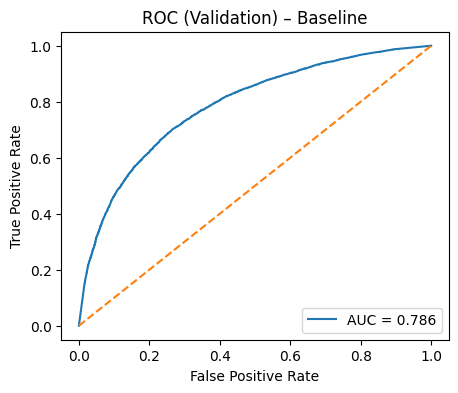

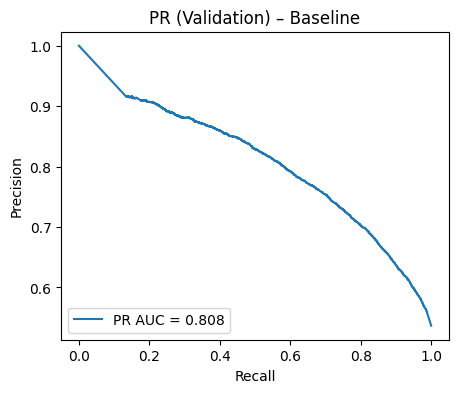

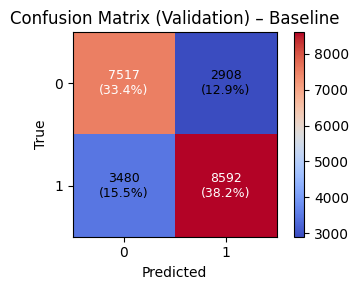

In [13]:
# Gráficos
plot_roc(y_valid, y_valid_proba, title='ROC (Validation) – Baseline')
plot_pr(y_valid, y_valid_proba, title='PR (Validation) – Baseline')
plot_confusion(y_valid, y_valid_proba, threshold=0.5,
               title='Confusion Matrix (Validation) – Baseline',
               cmap="coolwarm")

**Interpretação:**  a linha de base `roc_auc` indica já um modelo com grande capacidade de separação das classes (~80%). Avançamos para *tuning* para procurar oportunidades de melhoria.

## 9. Tuning Leve (RandomizedSearchCV)

In [14]:
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV

cv2 = StratifiedKFold(n_splits=2, shuffle=True, random_state=SEED)

param_distributions = {
    'clf__n_estimators': [200, 300, 400, 600],
    'clf__max_depth': [None, 8, 12, 16, 24],
    'clf__min_samples_leaf': [1, 2, 5],
    'clf__min_samples_split': [2, 5, 10],
    'clf__max_features': ['sqrt', 'log2', 0.5],
}

rs = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions,
    n_iter=50,            # 6–8 é bom para “fast”
    scoring='average_precision',
    cv=cv2,
    random_state=SEED,
    n_jobs=-1,
    verbose=1
)

rs.fit(X_train, y_train)
print('Best params:', rs.best_params_)
print()
best_pipeline = rs.best_estimator_
y_valid_proba_best = best_pipeline.predict_proba(X_valid)[:, 1]

best_metrics = compute_metrics(y_valid, y_valid_proba_best, threshold=0.5)
print(json.dumps({k: float(v) for k, v in best_metrics.items()}, indent=2))


Fitting 2 folds for each of 50 candidates, totalling 100 fits


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best params: {'clf__n_estimators': 600, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 2, 'clf__max_features': 'log2', 'clf__max_depth': None}

{
  "accuracy": 0.716762234964662,
  "precision": 0.7468387320284081,
  "recall": 0.714297548045063,
  "f1": 0.7302057752561606,
  "f0.5": 0.7400954408129635,
  "roc_auc": 0.7907279027672494
}


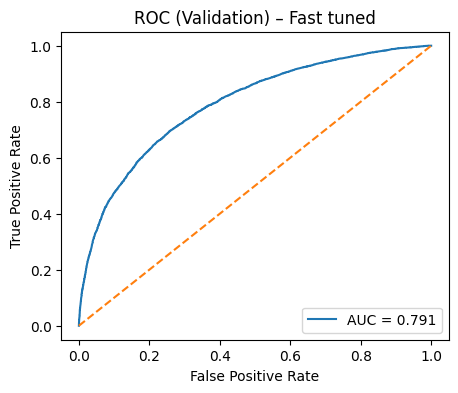

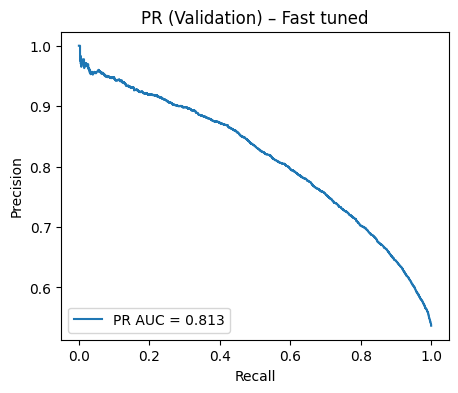

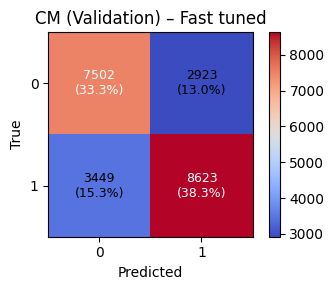

In [15]:
plot_roc(y_valid, y_valid_proba_best, title='ROC (Validation) – Fast tuned')
plot_pr(y_valid, y_valid_proba_best, title='PR (Validation) – Fast tuned')
plot_confusion(y_valid, y_valid_proba_best, threshold=0.5, title='CM (Validation) – Fast tuned',cmap="coolwarm")

**Trade-offs (bias/variance):**  
- **`max_depth`**, **`min_samples_leaf`** e **`min_samples_split`** controlam complexidade vs. generalização, demos oportunidade de encontrar diferentes configurações.  
- **`max_features`** regula a aleatoriedade de cada árvore e melhora rebostez evitando domínio de variáveis.
- No *tuning*, as melhorias no *validation* foram marginais face ao custo de treino de até 1 hora com seleção de 50 estimadores.

## 10. Threshold Tuning

,accuracy,precision,recall,f1,f0.5,roc_auc,threshold
0,0.5887,0.5674,0.9829,0.7194,0.6198,0.7907,0.10
1,0.6168,0.5870,0.9643,0.7298,0.6368,0.7907,0.15
2,0.6409,0.6061,0.9452,0.7386,0.6529,0.7907,0.20
3,0.6679,0.6309,0.9186,0.7480,0.6730,0.7907,0.25
4,0.6876,0.6548,0.8835,0.7522,0.6906,0.7907,0.30
5,0.7010,0.6769,0.8472,0.7525,0.7052,0.7907,0.35
6,0.7112,0.6998,0.8086,0.7503,0.7192,0.7907,0.40
7,0.7164,0.7237,0.7626,0.7426,0.7311,0.7907,0.45
8,0.7168,0.7468,0.7143,0.7302,0.7401,0.7907,0.50
9,0.7131,0.7721,0.6602,0.7118,0.7468,0.7907,0.55


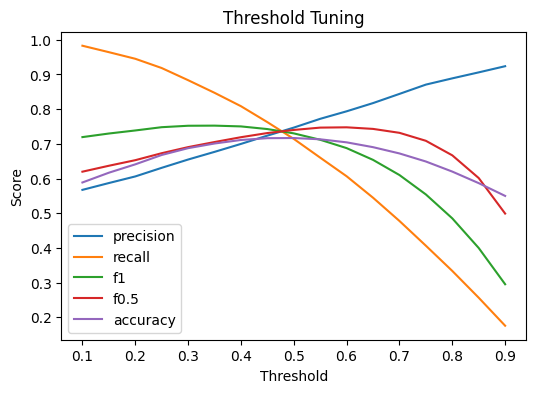

Chosen threshold for max F0.5 on validation: 0.6


In [16]:
# Objetivo foi perceber de que forma a variação do threshold impacta as métricas de avaliação do modelo
thr_grid = np.linspace(0.1, 0.9, 17)
thr_df = threshold_tuning(y_valid, y_valid_proba_best, thresholds=thr_grid)
display(thr_df.round(4))
plot_threshold_curves(thr_df)

# Critério escolhido foi o f0.5 que atribuí 2x mais importância à Precision vs Recall
best_thr_row = thr_df.iloc[thr_df['f0.5'].idxmax()]
BEST_THR = float(best_thr_row['threshold'])
print('Chosen threshold for max F0.5 on validation:', BEST_THR)

## 11. Avaliação Final no Test Set

### 11.1 Avaliação com best threshold para F0.5



Final metrics (test, thr=0.50):
{
  "accuracy": 0.7227630350713429,
  "precision": 0.7530575071558678,
  "recall": 0.7191848906560636,
  "f1": 0.7357315367992882,
  "f0.5": 0.7460301093008868,
  "roc_auc": 0.7920130337082223
}

Final metrics (test, thr=BEST_THR):
{
  "accuracy": 0.7028048184202338,
  "precision": 0.7941883329691938,
  "recall": 0.6022200132538105,
  "f1": 0.6850089512861585,
  "f0.5": 0.7465905356556031,
  "roc_auc": 0.7920130337082223
}


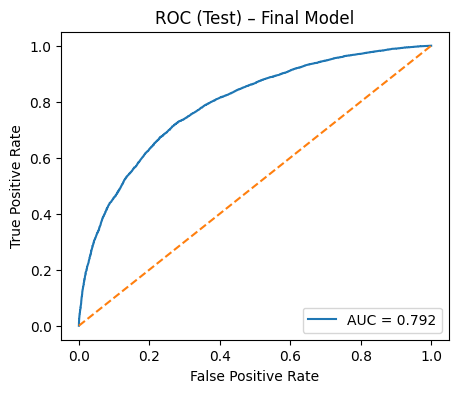

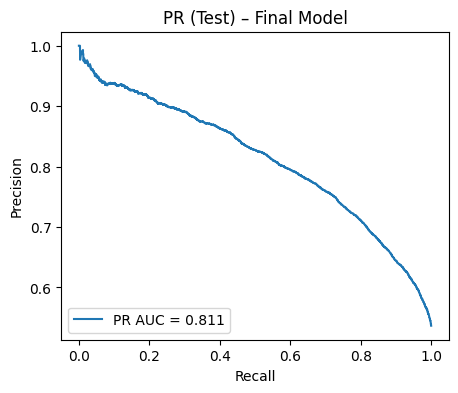

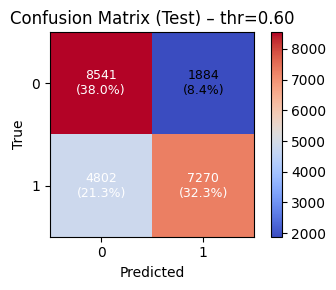

In [17]:

final_pipe = best_pipeline
y_test_proba = final_pipe.predict_proba(X_test)[:, 1]

final_metrics_thr50 = compute_metrics(y_test, y_test_proba, threshold=0.5)
final_metrics_best  = compute_metrics(y_test, y_test_proba, threshold=BEST_THR)

print('Final metrics (test, thr=0.50):')
print(json.dumps({k: float(v) for k, v in final_metrics_thr50.items()}, indent=2))
print('\nFinal metrics (test, thr=BEST_THR):')
print(json.dumps({k: float(v) for k, v in final_metrics_best.items()}, indent=2))

plot_roc(y_test, y_test_proba, title='ROC (Test) – Final Model')
plot_pr(y_test, y_test_proba, title='PR (Test) – Final Model')
plot_confusion(y_test, y_test_proba, threshold=BEST_THR, title=f'Confusion Matrix (Test) – thr={BEST_THR:.2f}',cmap="coolwarm")


Esta é a **fotografia** do desempenho fora da amostra com threshold que maximiza o F0.5.

### 11.2 Estudo do Threshold entre 0.5 e 0.6 (máx de F0.5)

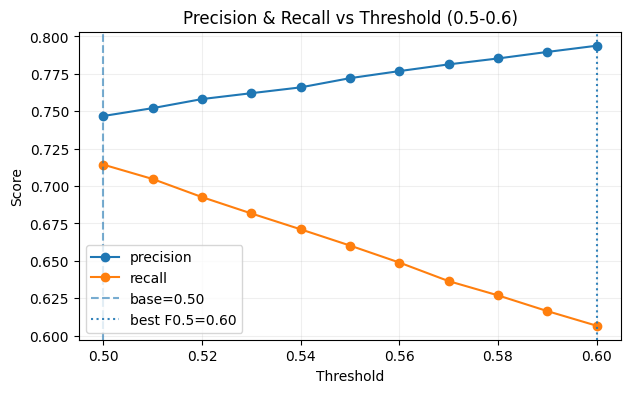

,accuracy,precision,recall,f1,f0.5,roc_auc,threshold,delta_precision_abs,delta_precision_rel_%,delta_recall_abs,delta_recall_rel_%,delta_accuracy_abs,delta_accuracy_rel_%,delta_f1_abs,delta_f1_rel_%,delta_f0.5_abs,delta_f0.5_rel_%
0,0.7168,0.7468,0.7143,0.7302,0.7401,0.7907,0.50,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.7169,0.7521,0.7047,0.7276,0.7421,0.7907,0.51,0.0053,0.7044,-0.0096,-1.3452,0.0001,0.0186,-0.0026,-0.3538,0.0020,0.2727
2,0.7165,0.7582,0.6926,0.7239,0.7441,0.7907,0.52,0.0113,1.5160,-0.0217,-3.0384,-0.0003,-0.0372,-0.0063,-0.8641,0.0040,0.5374
3,0.7150,0.7621,0.6817,0.7196,0.7445,0.7907,0.53,0.0152,2.0415,-0.0326,-4.5692,-0.0018,-0.2481,-0.0106,-1.4480,0.0044,0.5975
4,0.7135,0.7660,0.6711,0.7154,0.7449,0.7907,0.54,0.0191,2.5629,-0.0432,-6.0536,-0.0033,-0.4589,-0.0148,-2.0299,0.0048,0.6500
5,0.7131,0.7721,0.6602,0.7118,0.7468,0.7907,0.55,0.0253,3.3874,-0.0541,-7.5728,-0.0036,-0.5085,-0.0184,-2.5209,0.0067,0.9078
6,0.7116,0.7769,0.6489,0.7071,0.7474,0.7907,0.56,0.0300,4.0187,-0.0654,-9.1615,-0.0052,-0.7256,-0.0231,-3.1630,0.0073,0.9825
7,0.7093,0.7813,0.6364,0.7015,0.7473,0.7907,0.57,0.0345,4.6208,-0.0779,-10.9011,-0.0074,-1.0357,-0.0287,-3.9334,0.0072,0.9755
8,0.7078,0.7853,0.6269,0.6972,0.7475,0.7907,0.58,0.0385,5.1508,-0.0874,-12.2347,-0.0089,-1.2465,-0.0330,-4.5170,0.0074,1.0046
9,0.7060,0.7897,0.6164,0.6923,0.7476,0.7907,0.59,0.0428,5.7342,-0.0979,-13.7075,-0.0107,-1.4946,-0.0379,-5.1847,0.0075,1.0179


In [18]:
def fine_threshold_sweep(y_true, y_prob, start=0.50, end=0.60, step=0.01, base_thr=0.50):
    # 1) Grelha fina
    fine_thr = np.round(np.arange(start, end + 1e-9, step), 2)
    thr_df_fine = threshold_tuning(y_true, y_prob, thresholds=fine_thr)

    # 2) Deltas vs base
    base_vals = thr_df_fine.loc[thr_df_fine['threshold'] == base_thr].iloc[0]
    for m in ['precision', 'recall', 'accuracy', 'f1', 'f0.5']:
        thr_df_fine[f'delta_{m}_abs'] = thr_df_fine[m] - base_vals[m]
        thr_df_fine[f'delta_{m}_rel_%'] = 100 * thr_df_fine[f'delta_{m}_abs'] / (base_vals[m] if base_vals[m] != 0 else 1)

    # 3) Melhor por F0.5
    best_f05_row = thr_df_fine.iloc[thr_df_fine['f0.5'].idxmax()]
    best_thr_f05 = float(best_f05_row['threshold'])

    # 4) Gráfico só com as duas linhas verticais
    plt.figure(figsize=(7,4))
    plt.plot(thr_df_fine['threshold'], thr_df_fine['precision'], marker='o', label='precision')
    plt.plot(thr_df_fine['threshold'], thr_df_fine['recall'], marker='o', label='recall')
    plt.axvline(base_thr, linestyle='--', alpha=0.6, label=f'base={base_thr:.2f}')
    plt.axvline(best_thr_f05, linestyle=':', alpha=0.9, label=f'best F0.5={best_thr_f05:.2f}')
    plt.xlabel('Threshold'); plt.ylabel('Score'); plt.title(f'Precision & Recall vs Threshold ({start}-{end})')
    plt.legend(); plt.grid(True, alpha=0.2)
    plt.show()

    # 5) Retornar tabela
    return thr_df_fine.round(4)

# Executar avalição fina de comparação do trade-off
thr_df_fine = fine_threshold_sweep(y_valid, y_valid_proba_best)
display(thr_df_fine)


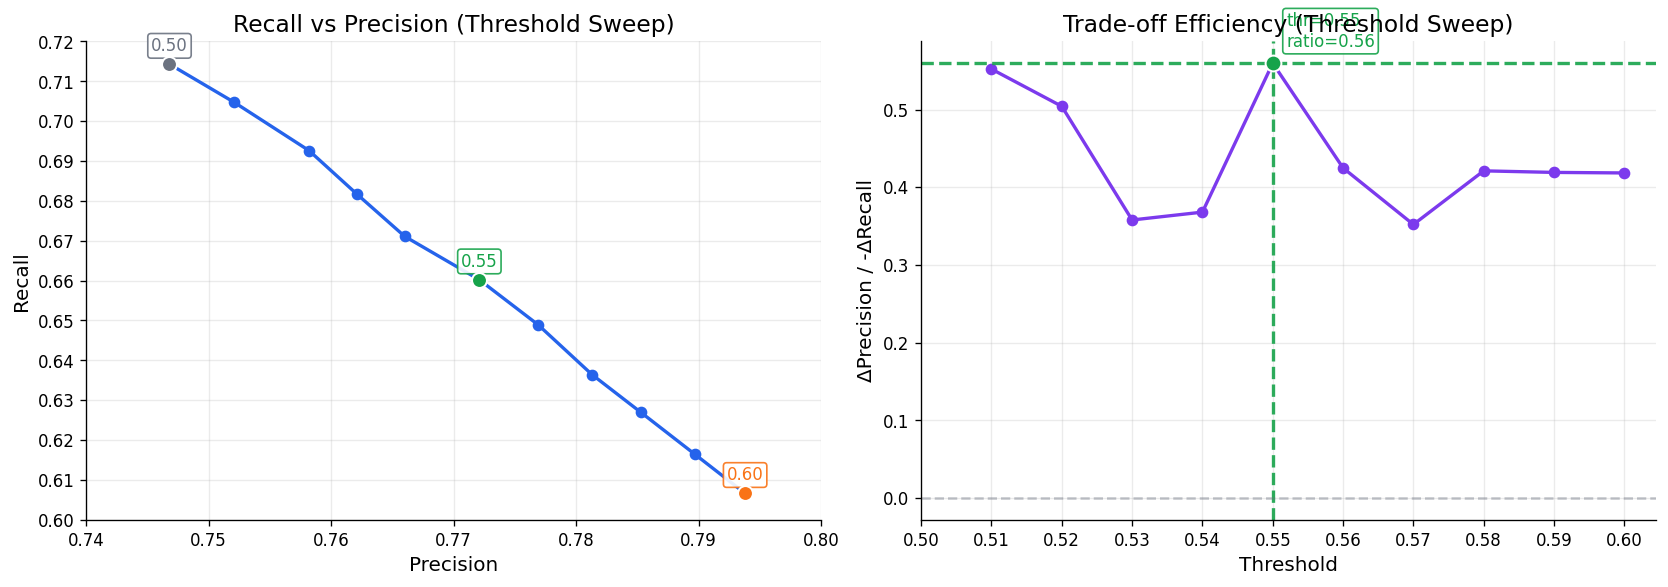

In [19]:
# Usar a grelha fina como base para os gráficos
thr_tradeoff = thr_df_fine.copy()

# Se ainda não existir, criar a coluna de eficiência do trade-off
if 'tradeoff_ratio' not in thr_tradeoff.columns:
    thr_tradeoff['tradeoff_ratio'] = (
        thr_tradeoff['precision'].diff() / (-thr_tradeoff['recall'].diff())
    )

# ---------- Config global de estilo (clean & pro) ----------
plt.rcParams.update({
    "figure.dpi": 120,
    "axes.grid": True,
    "grid.alpha": 0.25,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.frameon": False,
})

# thresholds a destacar
t_base = 0.50
t_opt  = 0.55   # escolhido por nós para avaliar - valor intermédio
t_alt  = 0.60

mark_df = (thr_tradeoff[thr_tradeoff['threshold'].isin([t_base, t_opt, t_alt])]
           .copy().sort_values('threshold'))

# Valor do trade-off no threshold ótimo
trade_opt = float(thr_tradeoff.loc[thr_tradeoff['threshold'] == t_opt, 'tradeoff_ratio'].iloc[0])

# Paleta (consistente)
C_BASE = "#6b7280"   # cinza
C_OPT  = "#16a34a"   # verde
C_ALT  = "#f97316"   # laranja
C_LINE = "#2563eb"   # azul para curvas principais
C_TRAD = "#7c3aed"   # roxo para trade-off

fig, ax = plt.subplots(1, 2, figsize=(14,5))

# ===================== (1) Recall vs Precision =====================
ax[0].plot(thr_tradeoff['precision'], thr_tradeoff['recall'],
           marker='o', lw=2, color=C_LINE)

# marcar apenas 0.50, 0.55, 0.60 com cores distintas
for thr, color in [(t_base, C_BASE), (t_opt, C_OPT), (t_alt, C_ALT)]:
    row = thr_tradeoff.loc[thr_tradeoff['threshold'] == thr].iloc[0]
    ax[0].scatter([row['precision']], [row['recall']], s=80, color=color, zorder=4, edgecolor="white", linewidth=1.2)
    ax[0].annotate(f"{thr:.2f}", (row['precision'], row['recall']),
                   textcoords="offset points", xytext=(0,8), ha='center', fontsize=10, color=color,
                   bbox=dict(boxstyle="round,pad=0.2", fc="white", ec=color, alpha=0.9))

ax[0].set_xlabel("Precision")
ax[0].set_ylabel("Recall")
ax[0].set_title("Recall vs Precision (Threshold Sweep)")

# grid fino de 0.01 nos dois eixos
x_min, x_max = thr_tradeoff['precision'].min(), thr_tradeoff['precision'].max()
y_min, y_max = thr_tradeoff['recall'].min(),    thr_tradeoff['recall'].max()
ax[0].set_xticks(np.round(np.arange(np.floor(x_min*100)/100, np.ceil(x_max*100)/100+0.001, 0.01), 2))
ax[0].set_yticks(np.round(np.arange(np.floor(y_min*100)/100, np.ceil(y_max*100)/100+0.001, 0.01), 2))

# ===================== (2) Trade-off Efficiency =====================
ax[1].plot(thr_tradeoff['threshold'], thr_tradeoff['tradeoff_ratio'],
           marker='o', lw=2, color=C_TRAD)

# linhas guia (vertical & horizontal) no threshold ótimo
ax[1].axvline(t_opt, linestyle='--', color=C_OPT, lw=2, alpha=0.9)
ax[1].axhline(trade_opt, linestyle='--', color=C_OPT, lw=2, alpha=0.9)
ax[1].scatter([t_opt], [trade_opt], color=C_OPT, s=90, zorder=4, edgecolor="white", linewidth=1.2)

ax[1].annotate(f"thr={t_opt:.2f}\nratio={trade_opt:.2f}",
               (t_opt, trade_opt), textcoords="offset points",
               xytext=(8,10), ha='left', fontsize=10, color=C_OPT,
               bbox=dict(boxstyle="round,pad=0.2", fc="white", ec=C_OPT, alpha=0.9))

# eixo X com ticks de 0.01 (0.50–0.60)
ax[1].set_xticks(np.round(np.arange(0.50, 0.60+0.001, 0.01), 2))
ax[1].axhline(0, linestyle='--', color=C_BASE, alpha=0.4)

ax[1].set_xlabel("Threshold")
ax[1].set_ylabel("ΔPrecision / -ΔRecall")
ax[1].set_title("Trade-off Efficiency (Threshold Sweep)")

plt.tight_layout()
plt.show()


### 11.3 Avalidação no Test Set com Chosen Threshold = 0.5



Final metrics (test, thr=0.50):
{
  "accuracy": 0.7227630350713429,
  "precision": 0.7530575071558678,
  "recall": 0.7191848906560636,
  "f1": 0.7357315367992882,
  "f0.5": 0.7460301093008868,
  "roc_auc": 0.7920130337082223
}

Final metrics (test, thr=0.50):
{
  "accuracy": 0.7227630350713429,
  "precision": 0.7530575071558678,
  "recall": 0.7191848906560636,
  "f1": 0.7357315367992882,
  "f0.5": 0.7460301093008868,
  "roc_auc": 0.7920130337082223
}


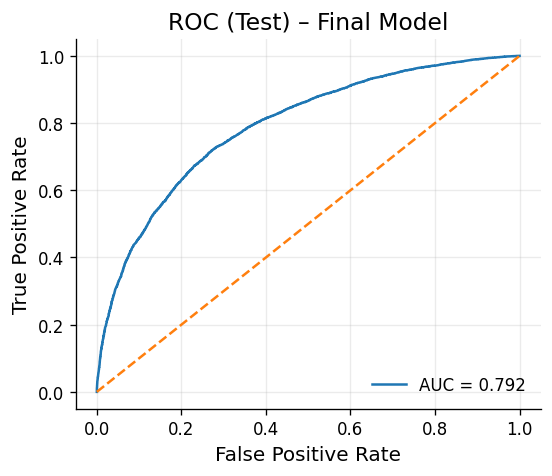

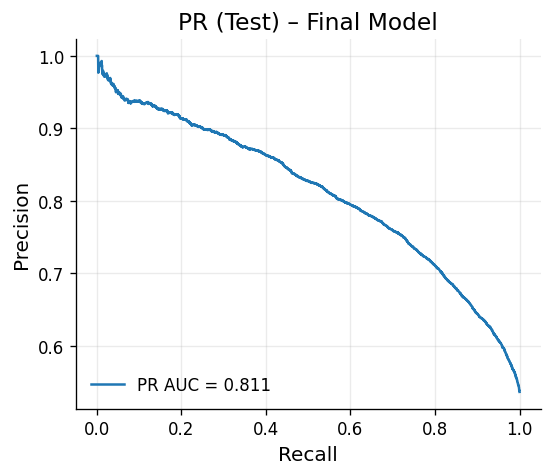

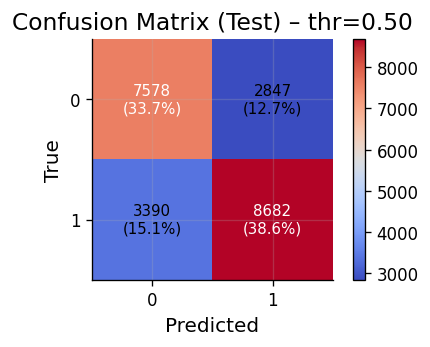

In [20]:
# Modelo final (já afinado no tuning)
final_pipe = best_pipeline

# Probabilidades no conjunto de teste
y_test_proba = final_pipe.predict_proba(X_test)[:, 1]

# Thresholds para avaliar
BASE_THR    = 0.50   # do base line
CHOSEN_THR  = 0.50   # <-- definido com base na análise trade-off

# Calcular métricas
final_metrics_base   = compute_metrics(y_test, y_test_proba, threshold=BASE_THR)
final_metrics_chosen = compute_metrics(y_test, y_test_proba, threshold=CHOSEN_THR)

# Impressão clara
print(f"Final metrics (test, thr={BASE_THR:.2f}):")
print(json.dumps({k: float(v) for k, v in final_metrics_base.items()}, indent=2))

print(f"\nFinal metrics (test, thr={CHOSEN_THR:.2f}):")
print(json.dumps({k: float(v) for k, v in final_metrics_chosen.items()}, indent=2))

# Plots
plot_roc(y_test, y_test_proba, title='ROC (Test) – Final Model')
plot_pr(y_test, y_test_proba, title='PR (Test) – Final Model')
plot_confusion(
    y_test, y_test_proba, threshold=CHOSEN_THR,
    title=f'Confusion Matrix (Test) – thr={CHOSEN_THR:.2f}',
    cmap="coolwarm"
)


## 12. Importância de Variáveis e Explicabilidade

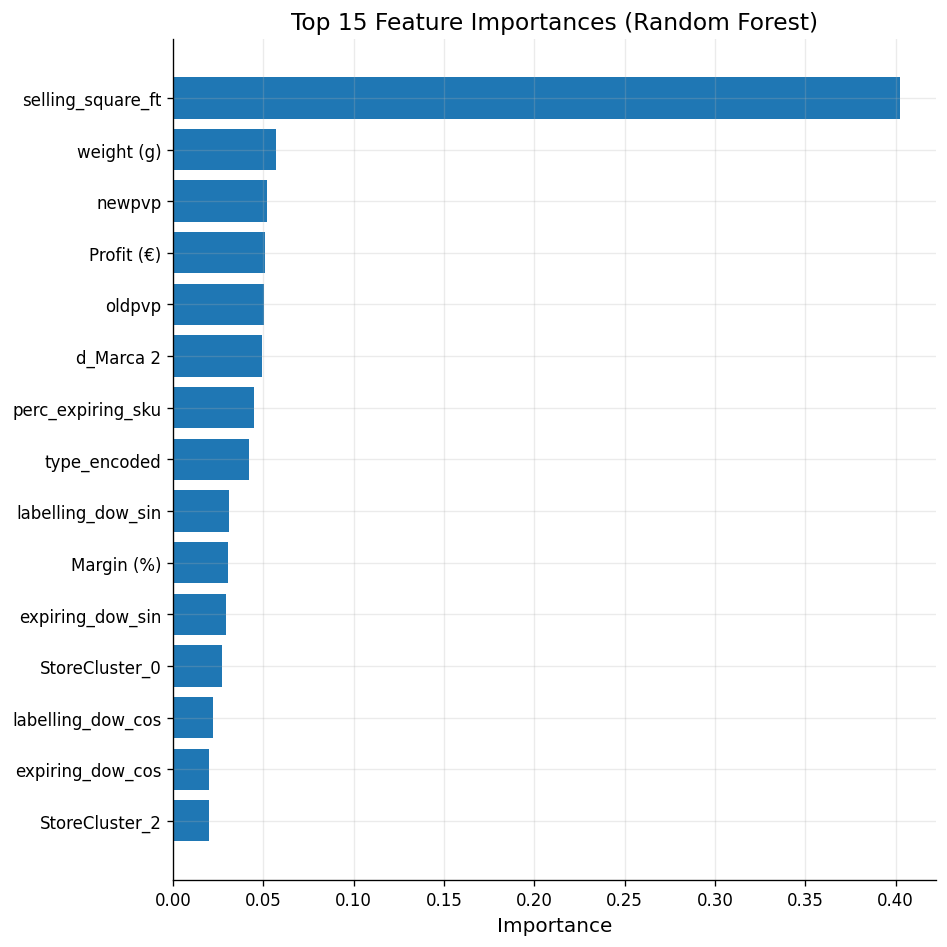

,feature,importance
5,selling_square_ft,0.402229
1,weight (g),0.057040
6,newpvp,0.052042
3,Profit (€),0.050679
0,oldpvp,0.050373
19,d_Marca 2,0.049003
4,perc_expiring_sku,0.045012
50,type_encoded,0.042156
51,labelling_dow_sin,0.030810
2,Margin (%),0.030561


In [21]:
# Extrair nomes de features após ColumnTransformer
def get_feature_names_from_ct(ct: ColumnTransformer) -> list:
    names = []
    for name, trans, cols in ct.transformers_:
        if trans == 'drop':
            continue
        # se não há colunas, ignora este bloco
        if cols is None or (hasattr(cols, '__len__') and len(cols) == 0):
            continue

        if hasattr(trans, 'named_steps'):
            last_step = list(trans.named_steps.values())[-1]
            # OneHotEncoder: só se já estiver fitado
            if isinstance(last_step, OneHotEncoder) and hasattr(last_step, 'categories_'):
                ohe_cols = last_step.get_feature_names_out(cols)
                names.extend(ohe_cols.tolist())
            else:
                names.extend(list(cols) if hasattr(cols, '__iter__') else [cols])
        else:
            names.extend(list(cols) if hasattr(cols, '__iter__') else [cols])
    return list(map(str, names))

feat_names = get_feature_names_from_ct(final_pipe.named_steps['pre'])
importances = final_pipe.named_steps['clf'].feature_importances_
fi = pd.DataFrame({'feature': feat_names, 'importance': importances}).sort_values('importance', ascending=False)

TOPN = 15
fig, ax = plt.subplots(figsize=(8,8))
ax.barh(fi['feature'].head(TOPN)[::-1], fi['importance'].head(TOPN)[::-1])
ax.set_xlabel('Importance'); ax.set_title(f'Top {TOPN} Feature Importances (Random Forest)')
plt.tight_layout(); plt.show()

display(fi.head(50))

**Notas:**
- As importâncias de RF medem redução média de impureza (úteis mas podem favorecer variáveis com mais níveis).
- Para maior robustez, podiamos considerar o **Permutation Importance**; para explicações locais, **SHAP** (em amostras).

## 13. Guardar Artefactos

In [22]:
timestamp = time.strftime('%Y%m%d_%H%M%S')
out_dir = f'model_outputs_{timestamp}'
os.makedirs(out_dir, exist_ok=True)

# Guardar pipeline final
model_path = os.path.join(out_dir, 'pink_rf_pipeline.joblib')
joblib.dump(final_pipe, model_path)

# Guardar métricas
metrics_path = os.path.join(out_dir, 'metrics_test.json')
with open(metrics_path, 'w') as f:
    json.dump({
        'threshold_used': float(BEST_THR),
        'test_metrics_thr_05': {k: float(v) for k, v in final_metrics_thr50.items()},
        'test_metrics_thr_best': {k: float(v) for k, v in final_metrics_best.items()}
    }, f, indent=2)

print('Artefactos guardados:')
print('  Modelo :', model_path)
print('  Métricas:', metrics_path)


Artefactos guardados:
  Modelo : model_outputs_20250925_144929/pink_rf_pipeline.joblib
  Métricas: model_outputs_20250925_144929/metrics_test.json


**Como recarregar**:

```python
import joblib
pipe = joblib.load('model_outputs_YYYYMMDD_HHMMSS/pink_rf_pipeline.joblib')
probas = pipe.predict_proba(novo_X)[:, 1]
preds = (probas >= 0.5).astype(int)  # ou usar o threshold BEST_THR que guardamos
```